In [1]:
import torch
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from src.models.decision_tree import DecisionTree
from src.metrics.regression_metrics import RegressionMetrics

# Load saved dataset
DATASET_PATH = "../data/london_bike_dataset.pt"
data = torch.load(DATASET_PATH)

X_reg = data['X']
y_reg = data['y']
feat_names = data['feature_names']

print(f"Loaded dataset: X={X_reg.shape}, y={y_reg.shape}")
print(f"Number of features: {len(feat_names)}")


Loaded dataset: X=torch.Size([17414, 14]), y=torch.Size([17414])
Number of features: 14


/tmp/ipykernel_65141/2952338138.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(DATASET_PATH)


In [2]:
# Manual train/test split (80/20) without sklearn
n_samples = X_reg.shape[0]
n_train = int(0.8 * n_samples)
indices = torch.randperm(n_samples)
train_indices = indices[:n_train]
test_indices = indices[n_train:]

X_train = X_reg[train_indices]
y_train = y_reg[train_indices]
X_test = X_reg[test_indices]
y_test = y_reg[test_indices]

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

# Train the model
tree_reg = DecisionTree(
    classification=False,
    max_depth=10,
    min_samples_split=2,
    criterion="mse",
    device="cuda",
)
tree_reg.fit(X_train, y_train)
print("Model trained successfully!")


Training set size: 13931
Test set size: 3483
Number of features: 14
Model trained successfully!


In [3]:
# Make predictions
y_train_pred = tree_reg.predict(X_train)
y_test_pred = tree_reg.predict(X_test)

# Calculate metrics
train_metrics = RegressionMetrics.metrics(y_train, y_train_pred)
test_metrics = RegressionMetrics.metrics(y_test, y_test_pred)

# Extract values
train_mse = train_metrics['mse'].item()
train_mae = train_metrics['mae'].item()
train_r2 = train_metrics['r2'].item()
test_mse = test_metrics['mse'].item()
test_mae = test_metrics['mae'].item()
test_r2 = test_metrics['r2'].item()

print("Training Metrics:")
print(f"  MSE: {train_mse:.2f}")
print(f"  MAE: {train_mae:.2f}")
print(f"  R²:  {train_r2:.4f}")
print("\nTest Metrics:")
print(f"  MSE: {test_mse:.2f}")
print(f"  MAE: {test_mae:.2f}")
print(f"  R²:  {test_r2:.4f}")


Training Metrics:
  MSE: 51035.80
  MAE: 128.96
  R²:  0.9568

Test Metrics:
  MSE: 79045.78
  MAE: 162.27
  R²:  0.9317


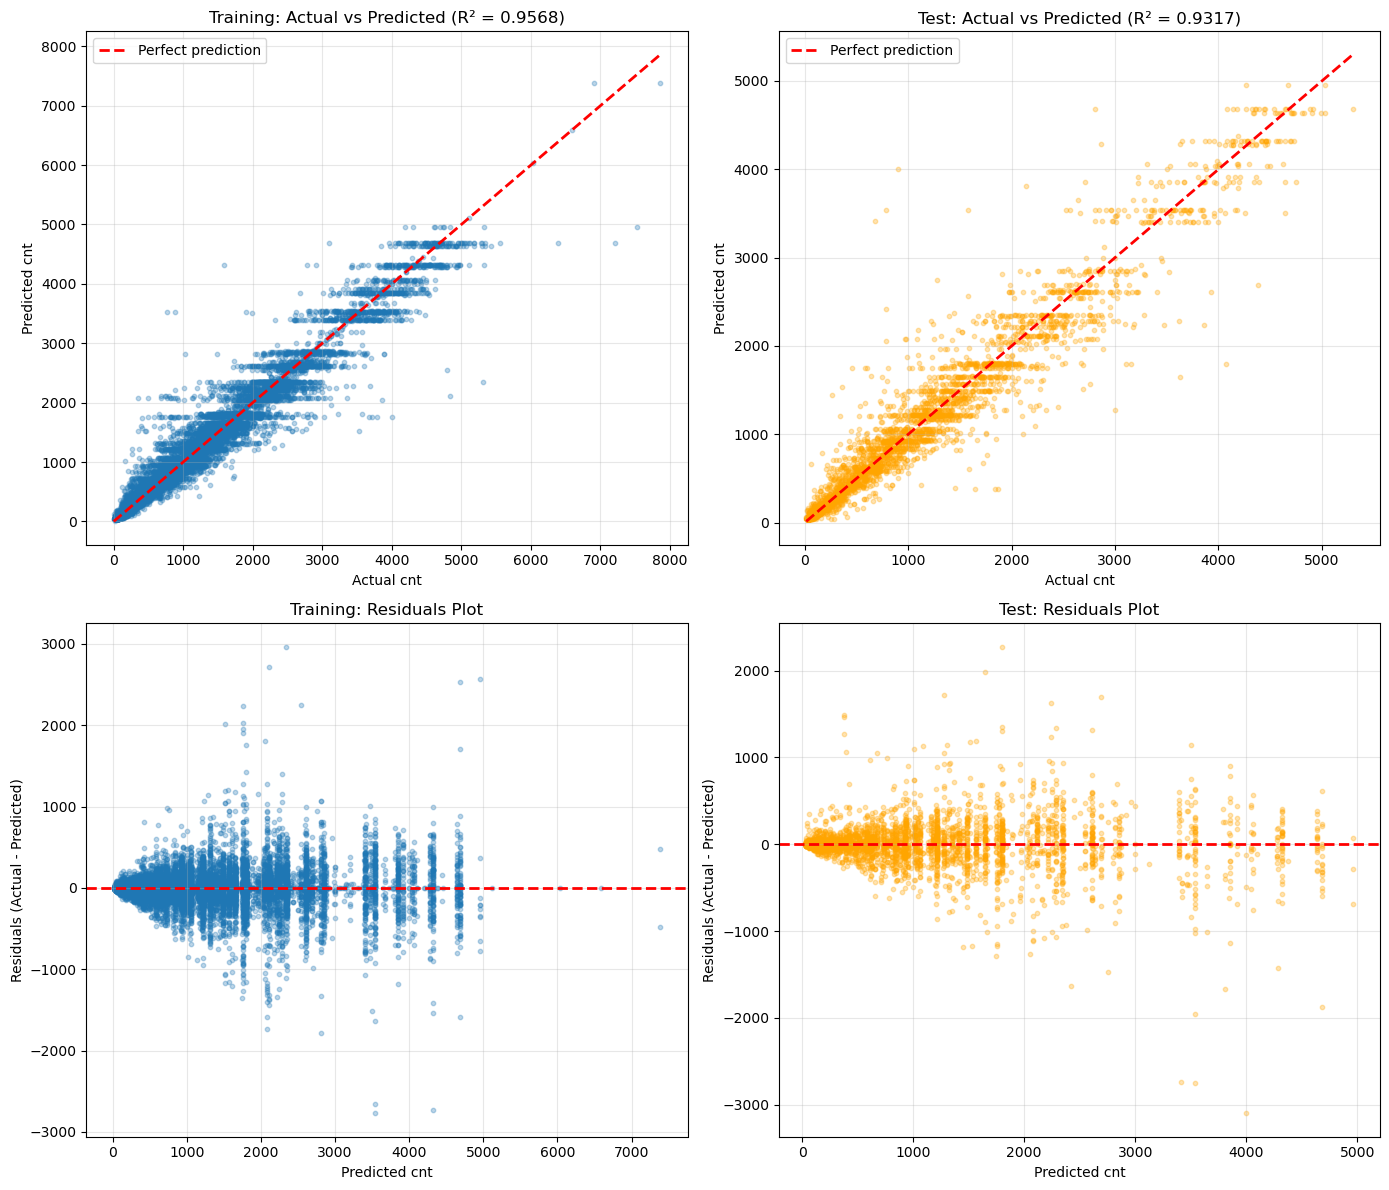

In [4]:
# Visualization plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Convert to numpy for plotting
y_train_np = y_train.numpy() if isinstance(y_train, torch.Tensor) else y_train
y_test_np = y_test.numpy() if isinstance(y_test, torch.Tensor) else y_test
y_train_pred_np = y_train_pred.numpy() if isinstance(y_train_pred, torch.Tensor) else y_train_pred
y_test_pred_np = y_test_pred.numpy() if isinstance(y_test_pred, torch.Tensor) else y_test_pred

# 1. Actual vs Predicted (Training)
axes[0, 0].scatter(y_train_np, y_train_pred_np, alpha=0.3, s=10)
axes[0, 0].plot([y_train_np.min(), y_train_np.max()], 
                [y_train_np.min(), y_train_np.max()], 
                'r--', lw=2, label='Perfect prediction')
axes[0, 0].set_xlabel('Actual cnt')
axes[0, 0].set_ylabel('Predicted cnt')
axes[0, 0].set_title(f'Training: Actual vs Predicted (R² = {train_r2:.4f})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted (Test)
axes[0, 1].scatter(y_test_np, y_test_pred_np, alpha=0.3, s=10, color='orange')
axes[0, 1].plot([y_test_np.min(), y_test_np.max()], 
                [y_test_np.min(), y_test_np.max()], 
                'r--', lw=2, label='Perfect prediction')
axes[0, 1].set_xlabel('Actual cnt')
axes[0, 1].set_ylabel('Predicted cnt')
axes[0, 1].set_title(f'Test: Actual vs Predicted (R² = {test_r2:.4f})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals plot (Training)
residuals_train = y_train_np - y_train_pred_np
axes[1, 0].scatter(y_train_pred_np, residuals_train, alpha=0.3, s=10)
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted cnt')
axes[1, 0].set_ylabel('Residuals (Actual - Predicted)')
axes[1, 0].set_title('Training: Residuals Plot')
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuals plot (Test)
residuals_test = y_test_np - y_test_pred_np
axes[1, 1].scatter(y_test_pred_np, residuals_test, alpha=0.3, s=10, color='orange')
axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Predicted cnt')
axes[1, 1].set_ylabel('Residuals (Actual - Predicted)')
axes[1, 1].set_title('Test: Residuals Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


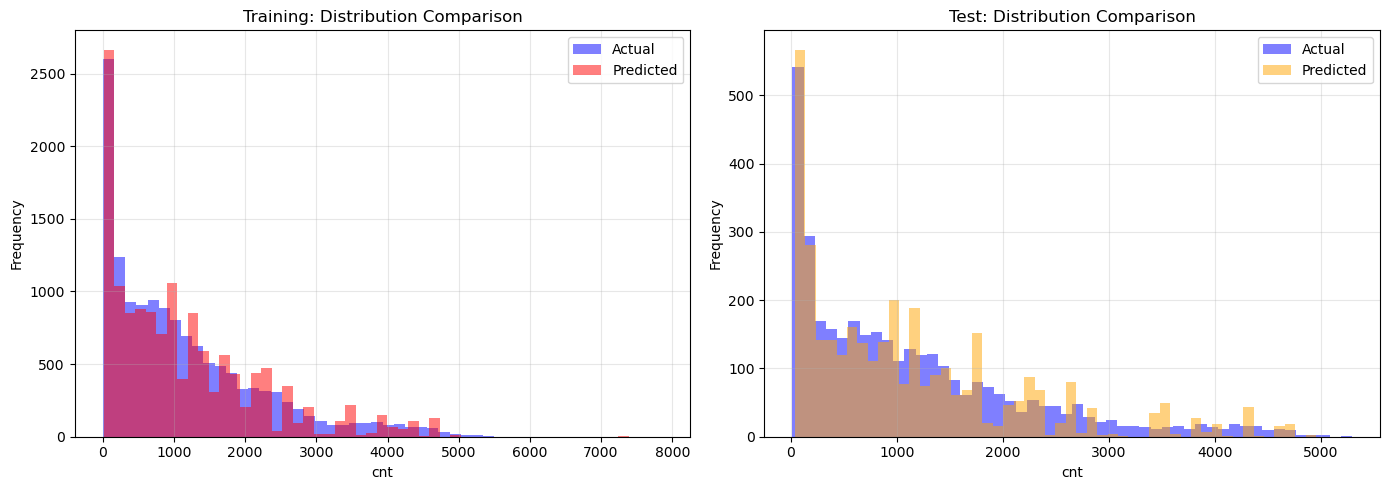

In [5]:
# Distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training distribution
axes[0].hist(y_train_np, bins=50, alpha=0.5, label='Actual', color='blue')
axes[0].hist(y_train_pred_np, bins=50, alpha=0.5, label='Predicted', color='red')
axes[0].set_xlabel('cnt')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Training: Distribution Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test distribution
axes[1].hist(y_test_np, bins=50, alpha=0.5, label='Actual', color='blue')
axes[1].hist(y_test_pred_np, bins=50, alpha=0.5, label='Predicted', color='orange')
axes[1].set_xlabel('cnt')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Test: Distribution Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [6]:
# Learning curves: performance vs max_depth
depths = list(range(1, 16))
train_mse_scores = []
train_mae_scores = []
train_r2_scores = []
test_mse_scores = []
test_mae_scores = []
test_r2_scores = []

print("Training models with different max_depth values...")
for depth in depths:
    # Train model with current depth
    tree = DecisionTree(
        classification=False,
        max_depth=depth,
        min_samples_split=2,
        criterion="mse",
        device="cuda",
    )
    tree.fit(X_train, y_train)
    
    # Predictions
    y_train_pred_curve = tree.predict(X_train)
    y_test_pred_curve = tree.predict(X_test)
    
    # Calculate metrics
    train_metrics_curve = RegressionMetrics.metrics(y_train, y_train_pred_curve)
    test_metrics_curve = RegressionMetrics.metrics(y_test, y_test_pred_curve)
    
    train_mse_scores.append(train_metrics_curve['mse'].item())
    train_mae_scores.append(train_metrics_curve['mae'].item())
    train_r2_scores.append(train_metrics_curve['r2'].item())
    test_mse_scores.append(test_metrics_curve['mse'].item())
    test_mae_scores.append(test_metrics_curve['mae'].item())
    test_r2_scores.append(test_metrics_curve['r2'].item())

print("Done!")


Training models with different max_depth values...
Done!


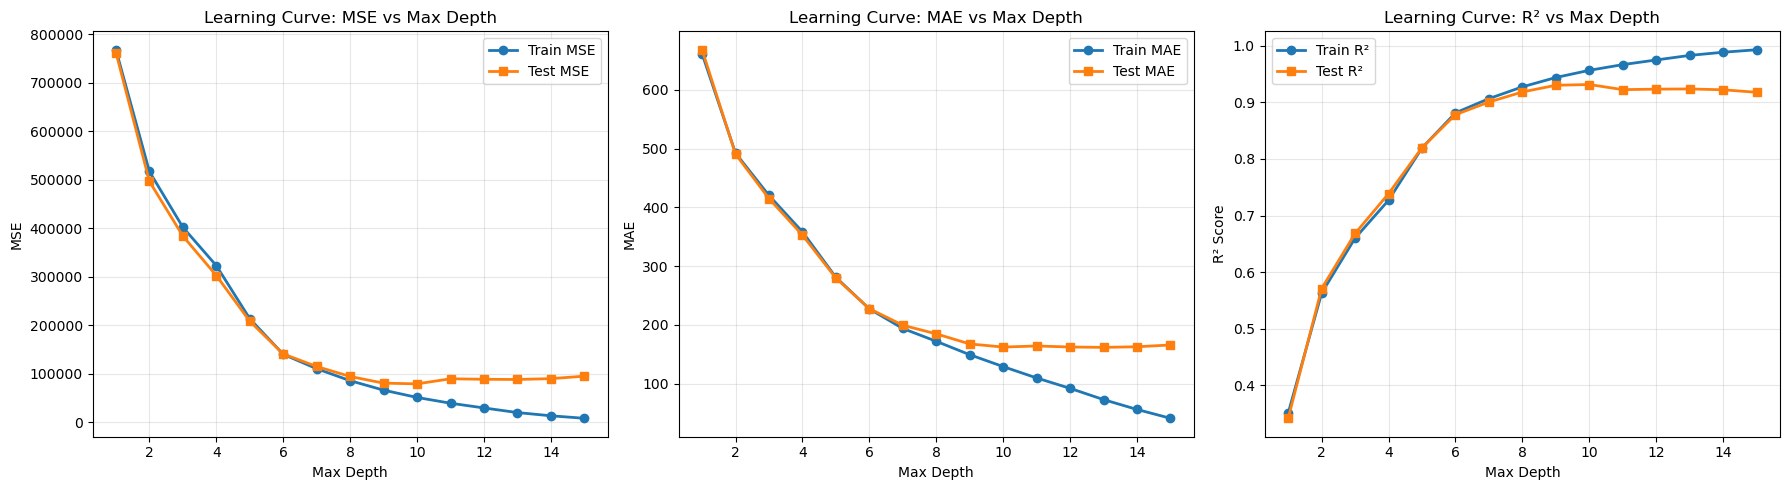


Best max_depth based on test R²: 10
Best test R²: 0.9317
Best test MSE: 79045.78
Best test MAE: 162.27


In [7]:
# Plot learning curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MSE plot
axes[0].plot(depths, train_mse_scores, 'o-', label='Train MSE', linewidth=2, markersize=6)
axes[0].plot(depths, test_mse_scores, 's-', label='Test MSE', linewidth=2, markersize=6)
axes[0].set_xlabel('Max Depth')
axes[0].set_ylabel('MSE')
axes[0].set_title('Learning Curve: MSE vs Max Depth')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE plot
axes[1].plot(depths, train_mae_scores, 'o-', label='Train MAE', linewidth=2, markersize=6)
axes[1].plot(depths, test_mae_scores, 's-', label='Test MAE', linewidth=2, markersize=6)
axes[1].set_xlabel('Max Depth')
axes[1].set_ylabel('MAE')
axes[1].set_title('Learning Curve: MAE vs Max Depth')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# R² plot
axes[2].plot(depths, train_r2_scores, 'o-', label='Train R²', linewidth=2, markersize=6)
axes[2].plot(depths, test_r2_scores, 's-', label='Test R²', linewidth=2, markersize=6)
axes[2].set_xlabel('Max Depth')
axes[2].set_ylabel('R² Score')
axes[2].set_title('Learning Curve: R² vs Max Depth')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best depth
best_test_idx = np.argmax(test_r2_scores)
best_depth = depths[best_test_idx]
print(f"\nBest max_depth based on test R²: {best_depth}")
print(f"Best test R²: {test_r2_scores[best_test_idx]:.4f}")
print(f"Best test MSE: {test_mse_scores[best_test_idx]:.2f}")
print(f"Best test MAE: {test_mae_scores[best_test_idx]:.2f}")
